# **Regresión Dinámica Inversa para doble péndulo**

In [59]:
import math
import numpy as np
import tensorflow as tf
import keras 
import pandas as pd
import json
import os
#from tensorflow import keras
from keras.models import Sequential #One of the most important classes in tensorflow, used to creare NN (Named after NN as a sequence of layers)
from keras.layers import Input, Dense, LSTM, BatchNormalization, Dropout #Dense layer means that one neuron in one layer is connected to all neurons in the next layer
from keras.regularizers import l2, l1, l1_l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, RobustScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [60]:
datos_2LRP_random = pd.read_csv(f'./2lpr_randomsamples_2025_05_13-23_28_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
datos_2LRP_joint = pd.read_csv(f'./2lpr_jointmovement_2025_05_03-19_10_52.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
#datos_2LRP_joint = pd.read_csv(f'./2lpr_jointmovement_2025_05_21-13_16_02.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
datos_2LRP_cart = pd.read_csv(f'./2lpr_cartesianmovement_2025_05_05-22_50_57.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

In [61]:
pos_j1 = datos_2LRP_random.iloc[:,1].values
pos_j2 = datos_2LRP_random.iloc[:,2].values

vels_j1 = datos_2LRP_random.iloc[:,3].values
vels_j2 = datos_2LRP_random.iloc[:,4].values

accs_j1 = datos_2LRP_random.iloc[:,5].values
accs_j2 = datos_2LRP_random.iloc[:,6].values

torq_j1 = datos_2LRP_random.iloc[:,7].values
torq_j2 = datos_2LRP_random.iloc[:,8].values

In [62]:
time_joint = datos_2LRP_joint.iloc[:,1].values

pos_j1_joint = datos_2LRP_joint.iloc[:,2].values
pos_j2_joint = datos_2LRP_joint.iloc[:,3].values

vels_j1_joint = datos_2LRP_joint.iloc[:,4].values
vels_j2_joint = datos_2LRP_joint.iloc[:,5].values

accs_j1_joint = datos_2LRP_joint.iloc[:,6].values
accs_j2_joint = datos_2LRP_joint.iloc[:,7].values

torq_j1_joint = datos_2LRP_joint.iloc[:,8].values
torq_j2_joint = datos_2LRP_joint.iloc[:,9].values

In [63]:
time_cart = datos_2LRP_cart.iloc[:,1].values

pos_j1_cart = datos_2LRP_cart.iloc[:,2].values
pos_j2_cart = datos_2LRP_cart.iloc[:,3].values

vels_j1_cart = datos_2LRP_cart.iloc[:,4].values
vels_j2_cart = datos_2LRP_cart.iloc[:,5].values

accs_j1_cart = datos_2LRP_cart.iloc[:,6].values
accs_j2_cart = datos_2LRP_cart.iloc[:,7].values

torq_j1_cart = datos_2LRP_cart.iloc[:,8].values
torq_j2_cart = datos_2LRP_cart.iloc[:,9].values

# **Red neuronal Secuencial (Same-step approach)**:

No es el entrenamiento de las redes lo que se compara, sino la calidad de los resultados finales. Cada red tiene una técnica de entrenamiento: las secuenciales no aprenden la correlación entre muestras, entonces es mejor entrenarlas con muestras descorrelacionadas -> ruido blanco, en cambio, las redes LSTM aprenden la historia y evolución del sistema (la correlación entre muestras), van a necesitar muestras ordenadas, secuencia de tiempo.

Problema Dinámico INVERSO: Dados las posiciones, velocidades y aceleraciones joint, obtener el valor de los torques necesarios para mantener esa posición.

En el método de same step approach, tengo que tener en cuenta cómo se describe la fórmula a analizar. Para el problema inverso, tengo en cuenta que la expresión de la dinámica es una función contínua, pero todo refiere al mismo instante de tiempo, ya que dadas las posiciones, velocidades y aceleraciones, el valor de torque obtenido es aquel para mantener esta posición. Entonces los valores de posición y velocidad son para el instante de tiempo del torque resultante. 

In [64]:
inputs_joint = np.vstack((pos_j1_joint, pos_j2_joint, vels_j1_joint, vels_j2_joint, accs_j1_joint, accs_j2_joint)).T
outputs_joint = np.vstack((torq_j1_joint, torq_j2_joint)).T
inputs_cart = np.vstack((pos_j1_cart, pos_j2_cart, vels_j1_cart, vels_j2_cart, accs_j1_cart, accs_j2_cart)).T
outputs_cart = np.vstack((torq_j1_cart, torq_j2_cart)).T

In [65]:
inputs_cart.shape
inputs_joint[:294660,:].shape

(294660, 6)

In [66]:
#inputs = np.vstack((inputs_joint[:294660,:], inputs_cart))
#outputs = np.vstack((outputs_joint[:294660,:], outputs_cart))
inputs = np.vstack([pos_j1, pos_j2, vels_j1, vels_j2, accs_j1, accs_j2]).T
outputs = np.vstack([torq_j1, torq_j2]).T

In [67]:
inputs.shape

(300000, 6)

In [68]:
X_train_FF_t, X_test_FF_t, y_train_FF_t, y_test_FF_t = train_test_split(inputs, outputs, test_size = 0.2)
#X_train_FF_t, X_val_FF_t, y_train_FF_t, y_val_FF_t = train_test_split(inputs, outputs, test_size = 0.2)

In [69]:
#Tengo que hacer preprocesado de los datos para que los calculos no sean tan pesados
scaler1_FF_t = RobustScaler() #RobustScaler()#
X_train_FF_t = scaler1_FF_t.fit_transform(X_train_FF_t)#Primero se llama a la funcion fit para que ajuste los datos
X_test_FF_t = scaler1_FF_t.transform(X_test_FF_t) #Una vez que los datos fueron ajustados se puede llamar a la transformacion directamente
#X_val_FF_t = scaler1_FF_t.transform(X_val_FF_t)

#Lo mismo para los outputs
scaler2_FF_t = RobustScaler() #RobustScaler()#
y_train_FF_t = scaler2_FF_t.fit_transform(y_train_FF_t)
y_test_FF_t = scaler2_FF_t.transform(y_test_FF_t)
#y_val_FF_t = scaler2_FF_t.transform(y_val_FF_t)

In [70]:
X_train_FF_t.shape

(240000, 6)

In [71]:
X_test_FF_t.shape

(60000, 6)

In [72]:
#X_val_FF_t.shape

🔄 Cargando modelo FF NN existente...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 50)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,008 (35.19 KB)

 Trainable params: 3,002 (11.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,006 (23.46 KB)

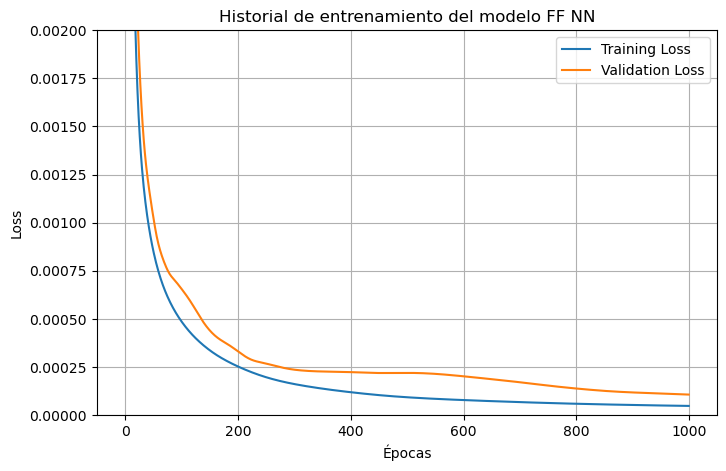

✅ Modelo FF NN listo para usar.


In [73]:
# Verificar si el modelo ya existe

FF_NN_model_path = "./2LPR/ID_NN/Modelos_NN/FF_NN_random/ff_nn_SS_Best_Model.keras"
FF_NN_history_path = "./2LPR/ID_NN/Modelos_NN/FF_NN_random/ff_nn_best_history.json"

if os.path.exists(FF_NN_model_path):
    print("🔄 Cargando modelo FF NN existente...")
    FF_SS_network = keras.models.load_model(FF_NN_model_path)
    FF_SS_network.summary()

    if os.path.exists(FF_NN_history_path):
        with open(FF_NN_history_path, "r") as f:
            FF_NN_history = json.load(f)  # Load the history data as a dictionary

        # Create a dummy History object for plotting:
        #FF_NN_history = type('DummyHistory', (object,), {'history': FF_NN_history_dict})()

        # Graficar el history
        plt.figure(figsize=(8, 5))
        plt.plot(FF_NN_history["loss"], label="Training Loss")
        plt.plot(FF_NN_history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.gca().set_ylim(0, 2e-3)
        plt.title("Historial de entrenamiento del modelo FF NN")
        plt.show()
    else:
        print("⚠️ No se encontró el archivo de history.")
else:
    print("⚙️ Creando nuevo modelo...")
    #Esta forma es lo más parecida posible al paper
    FF_SS_network = keras.models.Sequential([
        keras.layers.Input(shape=(inputs.shape[1],)),  # Input layer with the shape of the input data
        #keras.layers.LayerNormalization(epsilon=1e-4),
        keras.layers.Dense(50, activation="gelu"),
        #keras.layers.LayerNormalization(epsilon=1e-4),
        #keras.layers.Dropout(0.1),  # Dropout layer to prevent overfitting
        keras.layers.Dense(50, activation="gelu"),
        #keras.layers.Dense(50, activation="gelu"),
        #keras.layers.Dropout(0.1),  # Dropout layer to prevent overfitting        
        #keras.layers.Dense(64, activation="swish"),
        keras.layers.Dense(2)
    ])
    FF_SS_network.summary()

    FF_SS_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=5e-4), 
                          metrics = ['mae'])#Que pasa si uso SGD con learning rate

    checkpoint_cb = keras.callbacks.ModelCheckpoint(FF_NN_model_path, 
                                                    save_best_only=True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=200, min_delta=1e-10, restore_best_weights=True)

    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-8)       
    FF_NN_history = FF_SS_network.fit(X_train_FF_t, y_train_FF_t, epochs=1000, 
                                      batch_size=100, validation_split=0.3, shuffle=False, 
                                      callbacks=[checkpoint_cb, early_stopping_cb])

    with open(FF_NN_history_path, "w") as f:
        json.dump(FF_NN_history.history, f)
    with open(FF_NN_history_path, "r") as f:
        FF_NN_history = json.load(f)  # Load the history data as a dictionary

    # Create a dummy History object for plotting:
    #FF_NN_history = type('DummyHistory', (object,), {'history': FF_NN_history_dict})()

    pd.DataFrame(FF_NN_history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 2e-3)
    plt.show()

print("✅ Modelo FF NN listo para usar.")

In [74]:
accuracy_test_NN = FF_SS_network.evaluate(X_test_FF_t, y_test_FF_t)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.8602e-05 - mae: 0.0063


In [75]:
predictions_NN = FF_SS_network.predict(X_test_FF_t)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step


In [76]:
predictions_NN[0]

array([ 1.272493  , -0.03114581], dtype=float32)

In [77]:
y_test_FF_t[0]

array([ 1.26626506, -0.03134314])

# **Comparación de Modelos NN con otro conjunto de datos**

La comparación de los modelos 

In [78]:
#Uso el otro dataset joint

datos_2LRP_ref_joint = pd.read_csv(f'./2lpr_jointmovement_2024-10-03.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
#datos_2LRP_ref_joint.head()
t_ref = datos_2LRP_ref_joint.iloc[:,1].values

q1_ref = datos_2LRP_ref_joint.iloc[:,2].values
q2_ref = datos_2LRP_ref_joint.iloc[:,3].values

dq1_ref = datos_2LRP_ref_joint.iloc[:,4].values
dq2_ref = datos_2LRP_ref_joint.iloc[:,5].values

ddq1_ref = datos_2LRP_ref_joint.iloc[:,6].values
ddq2_ref = datos_2LRP_ref_joint.iloc[:,7].values

t1_ref = datos_2LRP_ref_joint.iloc[:,8].values
t2_ref = datos_2LRP_ref_joint.iloc[:,9].values
datos_2LRP_ref_joint.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.926178,-1.430799,0.001258,0.004265,1.257762,4.265447,-2.000074,-0.890958
1,2,0.001,-1.926176,-1.430793,0.002516,0.008531,1.257762,4.265447,-1.999438,-0.888827
2,3,0.002,-1.926173,-1.430782,0.003773,0.012796,1.257762,4.265447,-1.998798,-0.886697
3,4,0.003,-1.926168,-1.430767,0.005031,0.017062,1.257762,4.265447,-1.998153,-0.884568
4,5,0.004,-1.926163,-1.430748,0.006289,0.021327,1.257762,4.265447,-1.997503,-0.882441


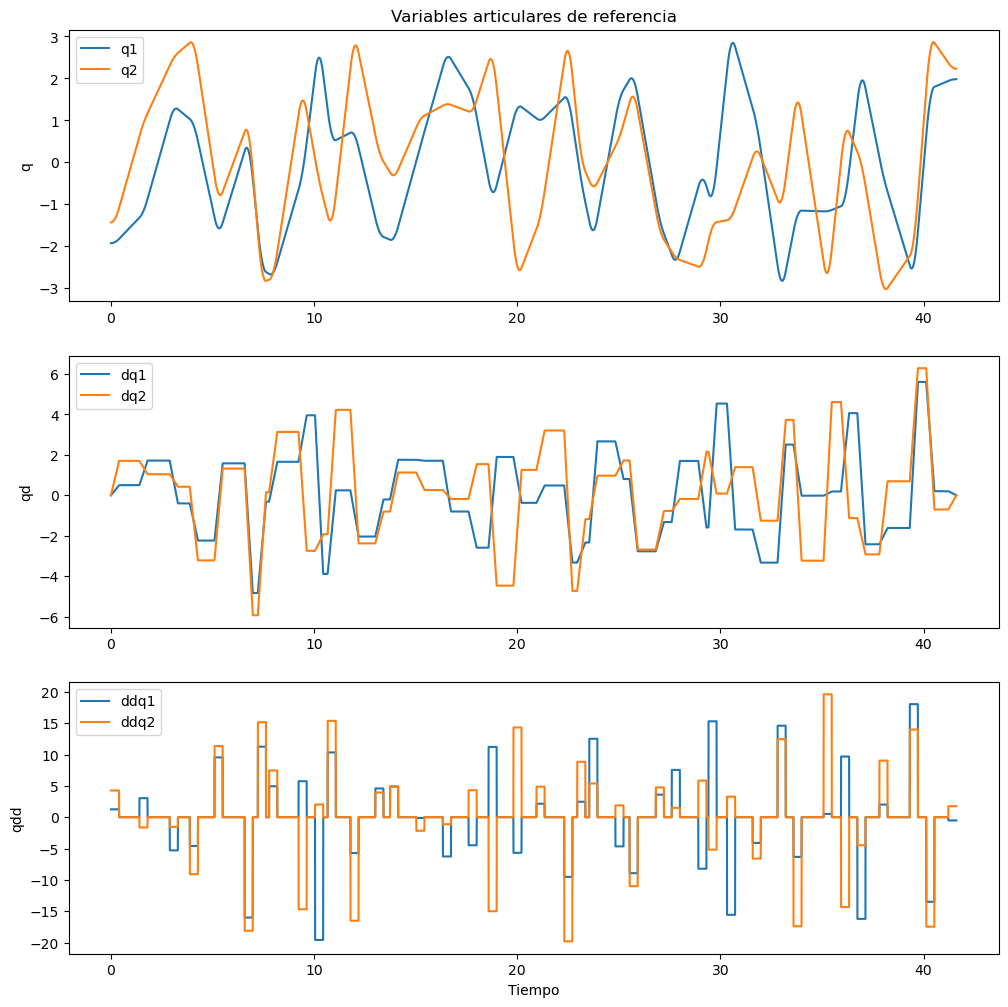

In [79]:
num_links = 2

plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
plt.plot(t_ref, q1_ref, label='q1')
plt.plot(t_ref, q2_ref, label='q2')
plt.legend();  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref, dq1_ref, label='dq1')
plt.plot(t_ref, dq2_ref, label='dq2')
plt.legend();  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref, ddq1_ref, label='ddq1')
plt.plot(t_ref, ddq2_ref, label='ddq2')
plt.legend(); plt.xlabel('Tiempo'); plt.ylabel('qdd')
plt.show()


In [80]:
inputs_ref = np.vstack((q1_ref,q2_ref,dq1_ref,dq2_ref,ddq1_ref,ddq2_ref)).T
outputs_ref = np.vstack((t1_ref,t2_ref)).T

In [81]:
#Primero con FF NN

X_test_scaled_FF_NN = scaler1_FF_t.transform(inputs_ref)
tau_sim_FF_NN = scaler2_FF_t.inverse_transform(FF_SS_network.predict(X_test_scaled_FF_NN))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step


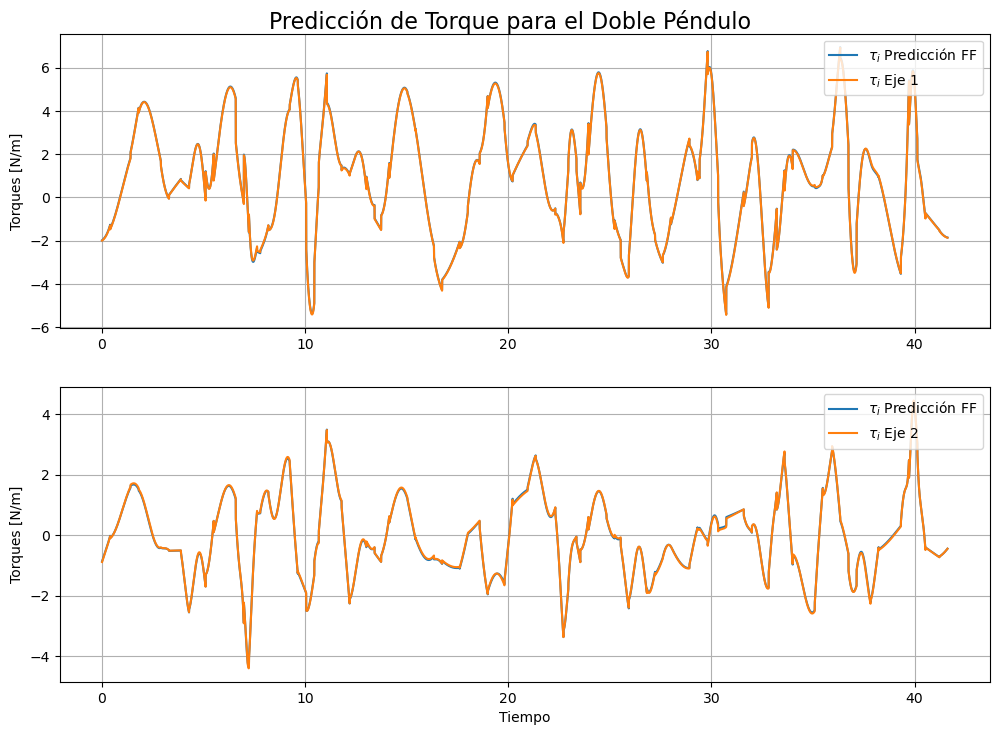

In [82]:
plt.figure(figsize=(12, 8)) 

# Agregar un título general
plt.suptitle("Predicción de Torque para el Doble Péndulo", fontsize=16, y=0.95)

# Grafico los resultados
for i in range(num_links):
  plt.subplot(num_links, 1, i+1)
  plt.plot(t_ref,tau_sim_FF_NN[:,i])
  plt.plot(t_ref,outputs_ref[:,i])
  plt.legend([r"$\tau_{i}$ Predicción FF", r"$\tau_{i}$ " f'Eje {i+1}'],loc='upper right', fontsize=10)
  plt.ylabel('Torques [N/m]')
  plt.grid(True)

plt.subplots_adjust(top=0.92)  
plt.xlabel('Tiempo');
plt.show()

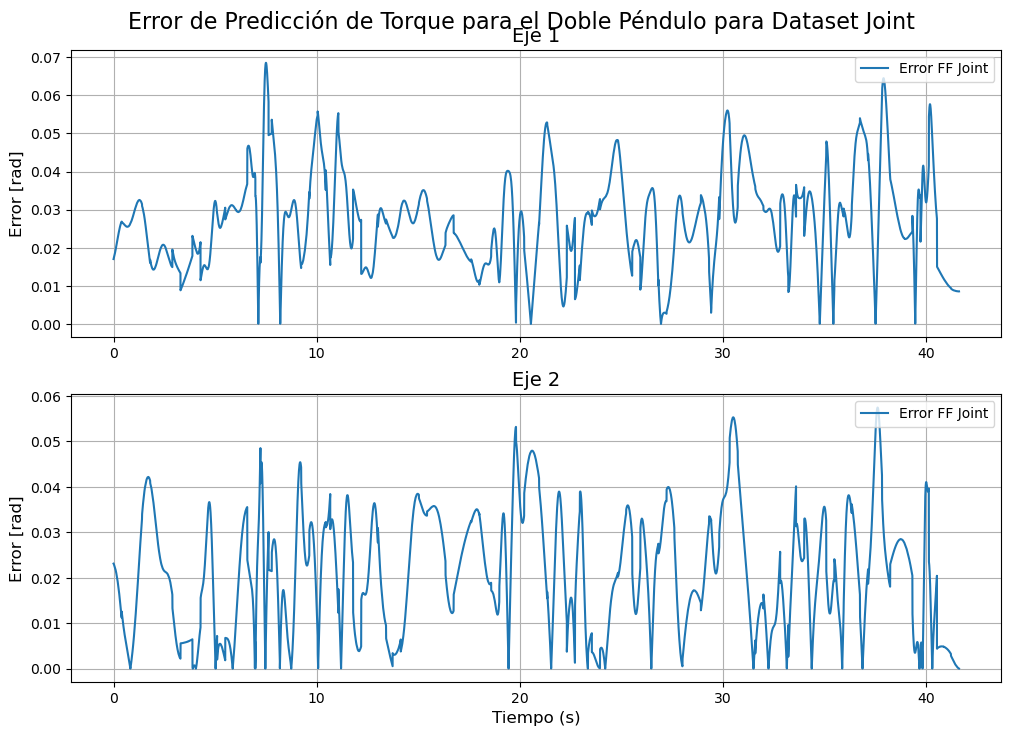

In [83]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Torque para el Doble Péndulo para Dataset Joint", fontsize=16,  y=0.95)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)

    error_SS_Joint_j = np.sqrt((tau_sim_FF_NN[:, i] - outputs_ref[:, i])**2)
    
    # Graficar los errores

    plt.plot(t_ref, error_SS_Joint_j, label='Error FF Joint')
 
    # Ajustar etiquetas y título del subplot
    plt.ylabel(r'Error [rad]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

plt.subplots_adjust(top=0.90)  

# Ajustar los espacios entre subplots
#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


**Estimación de Dataset Joint**

In [84]:
#Estimación de Dataset Joint
#Uso el otro dataset joint

datos_2LRP_comp_joint = pd.read_csv(f'./2lpr_jointmovement_2024_12_01-18_04_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

t_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,1].values

q1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,2].values
q2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,3].values

dq1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,4].values
dq2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,5].values

ddq1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,6].values
ddq2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,7].values

t1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,8].values
t2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,9].values
datos_2LRP_comp_joint.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.926178,-1.430799,0.001258,0.004265,1.257762,4.265447,-2.000074,-0.890958
1,2,0.001,-1.926176,-1.430793,0.002516,0.008531,1.257762,4.265447,-1.999438,-0.888827
2,3,0.002,-1.926173,-1.430782,0.003773,0.012796,1.257762,4.265447,-1.998798,-0.886697
3,4,0.003,-1.926168,-1.430767,0.005031,0.017062,1.257762,4.265447,-1.998153,-0.884568
4,5,0.004,-1.926163,-1.430748,0.006289,0.021327,1.257762,4.265447,-1.997503,-0.882441


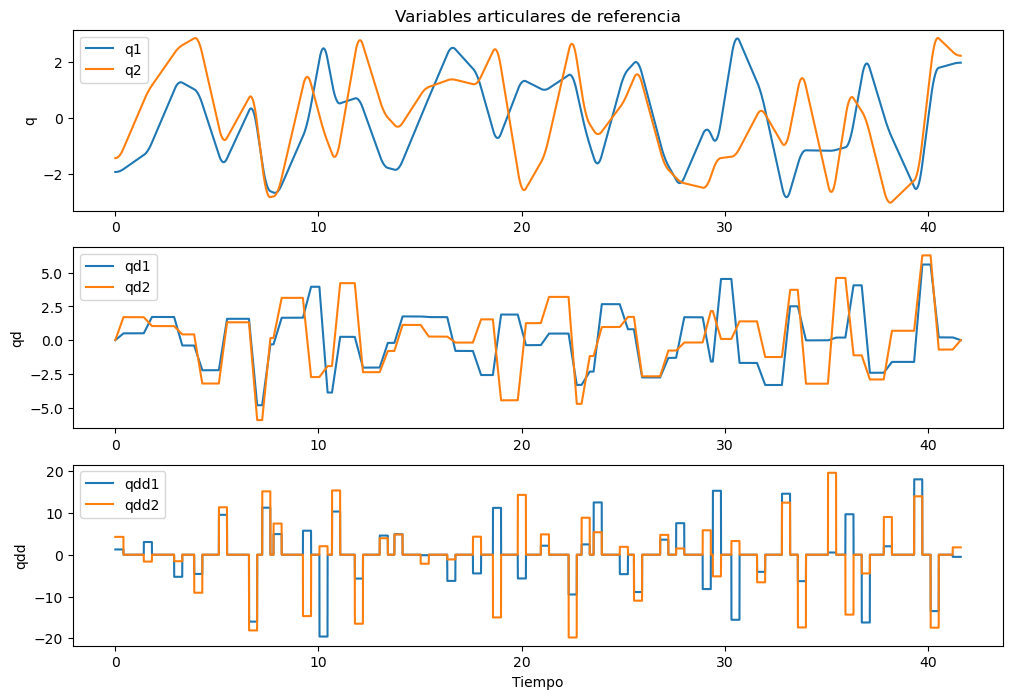

In [85]:
num_links = 2

plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(t_ref_comp_joint, q1_ref_comp_joint)
plt.plot(t_ref_comp_joint, q2_ref_comp_joint)
plt.legend(['q1', 'q2']);  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref_comp_joint, dq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, dq2_ref_comp_joint)
plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref_comp_joint, ddq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, ddq2_ref_comp_joint)
plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('qdd')
plt.show()

In [86]:
inputs_ref_comp_joint = np.vstack((q1_ref_comp_joint,q2_ref_comp_joint,dq1_ref_comp_joint,dq2_ref_comp_joint,ddq1_ref_comp_joint,ddq2_ref_comp_joint)).T
outputs_ref_comp_joint = np.vstack((t1_ref_comp_joint,t2_ref_comp_joint)).T

In [87]:
#Primero con FF NN entrenada con Joint
X_test_scaled_FF_NN_comp_joint_j = scaler1_FF_t.transform(inputs_ref_comp_joint)
tau_sim_FF_NN_comp_joint_j = scaler2_FF_t.inverse_transform(FF_SS_network.predict(X_test_scaled_FF_NN_comp_joint_j))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step


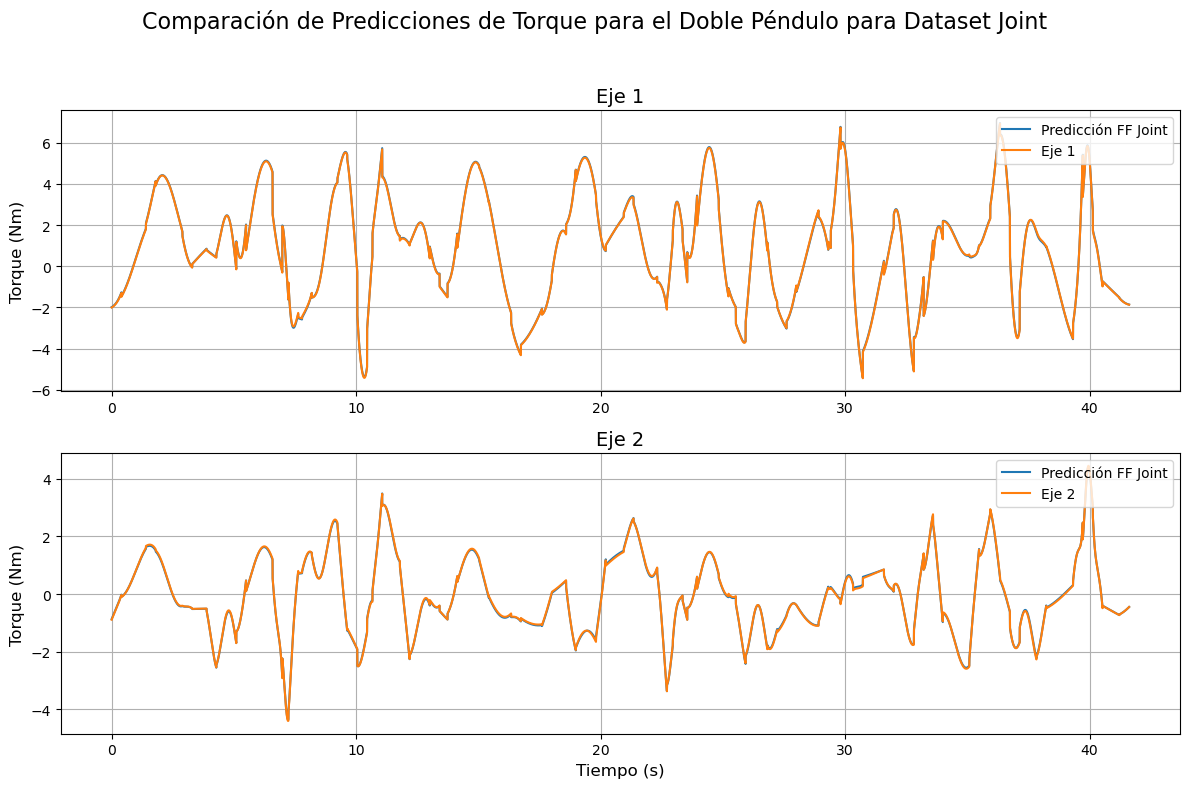

In [88]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Torque para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    #plt.plot(t_ref_comp_joint,tau_sim_FF_NN_comp_joint_c[:,i], label='Predicción FF Cart')
    plt.plot(t_ref_comp_joint,tau_sim_FF_NN_comp_joint_j[:,i], label='Predicción FF Joint')
    #plt.plot(t_ref_LSTM_comp_joint_c,tau_sim_LSTM_comp_joint_c[:,i], label='Predicción LSTM Cart')
    #plt.plot(t_ref_LSTM_comp_joint_j,tau_sim_LSTM_comp_joint_j[:,i], label='Predicción LSTM Joint')
    plt.plot(t_ref_comp_joint,outputs_ref_comp_joint[:,i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Torque (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()

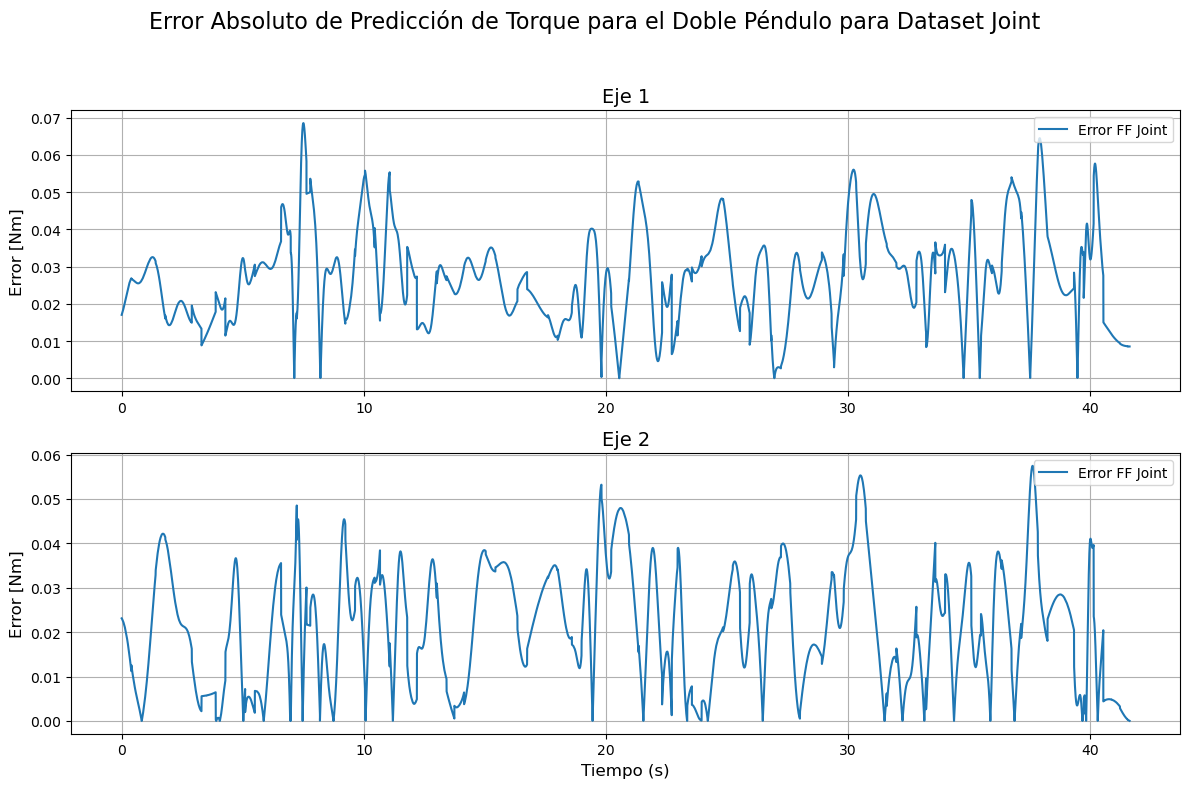

In [89]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título gen[w_size:]eral
plt.suptitle("Error Absoluto de Predicción de Torque para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Calcular errores
    error_OSA_Joint_j = np.sqrt((tau_sim_FF_NN_comp_joint_j[:, i] - outputs_ref_comp_joint[:, i])**2)
    

    # Graficar los errores
    #plt.plot(t_ref_comp_joint, error_OSA_Cart_j, label='Error FF Cart')
    plt.plot(t_ref_comp_joint, error_OSA_Joint_j, label='Error FF Joint')
    #plt.plot(t_ref_LSTM_comp_joint_c, error_LSTM_Cart_j, label='Error LSTM Cart')
    #plt.plot(t_ref_LSTM_comp_joint_j, error_LSTM_Joint_j, label='Error LSTM Joint')
    #plt.plot(t_ref_comp_joint[w_size:], error_LSTM_Cart_j, label='Error LSTM Cart')
    #plt.plot(t_ref_comp_joint[w_size:], error_LSTM_Joint_j, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error [Nm]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


**Estimación de Dataset Cartesiano**

In [90]:
#Estimación de Dataset Cartesiano

datos_2LRP_comp_cart = pd.read_csv(f'./2lpr_cartesianmovement_2024_12_01-18_04_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

t_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,1].values

q1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,2].values
q2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,3].values

dq1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,4].values
dq2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,5].values

ddq1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,6].values
ddq2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,7].values

t1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,8].values
t2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,9].values
datos_2LRP_comp_cart.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.174887,1.043499,-0.006224,0.011834,-4.149315,7.888932,2.095864,0.976848
1,2,0.001,-1.174893,1.043511,-0.010373,0.019723,-4.149118,7.888525,2.093779,0.980795
2,3,0.002,-1.174903,1.043531,-0.014523,0.027611,-4.148843,7.887955,2.091685,0.984743
3,4,0.003,-1.174918,1.043558,-0.018671,0.035499,-4.148489,7.887223,2.089583,0.988693
4,5,0.004,-1.174936,1.043594,-0.022820,0.043386,-4.148057,7.886328,2.087471,0.992643


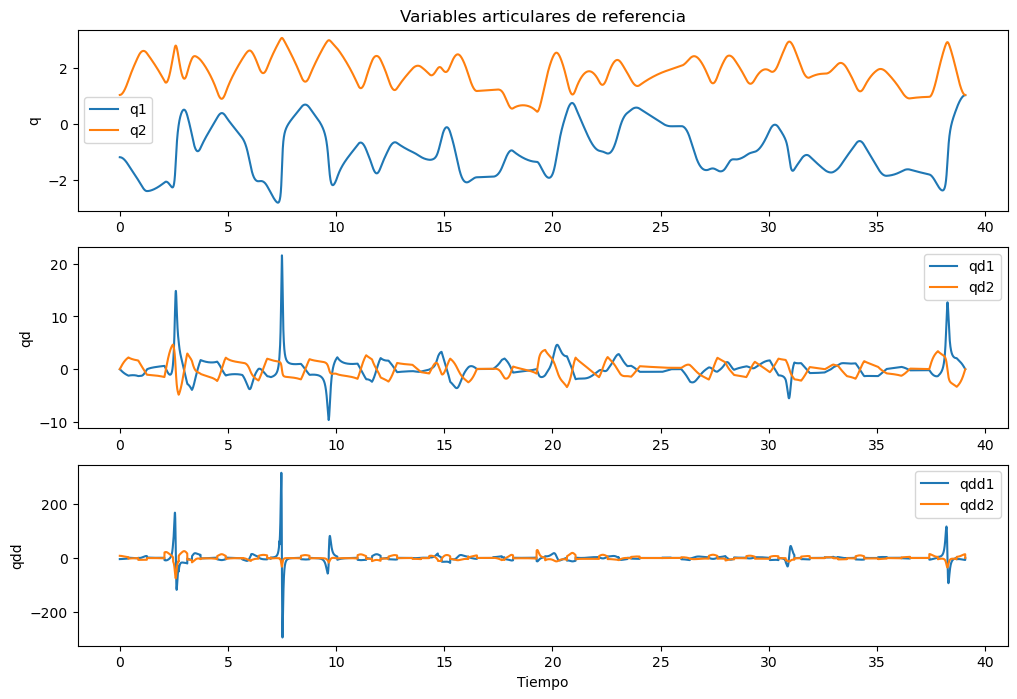

In [91]:
num_links = 2

plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(t_ref_comp_cart, q1_ref_comp_cart)
plt.plot(t_ref_comp_cart, q2_ref_comp_cart)
plt.legend(['q1', 'q2']);  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref_comp_cart, dq1_ref_comp_cart)
plt.plot(t_ref_comp_cart, dq2_ref_comp_cart)
plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref_comp_cart, ddq1_ref_comp_cart)
plt.plot(t_ref_comp_cart, ddq2_ref_comp_cart)
plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('qdd')
plt.show()

In [92]:
inputs_ref_comp_cart = np.vstack((q1_ref_comp_cart,q2_ref_comp_cart,dq1_ref_comp_cart,dq2_ref_comp_cart,ddq1_ref_comp_cart,ddq2_ref_comp_cart)).T
outputs_ref_comp_cart = np.vstack((t1_ref_comp_cart,t2_ref_comp_cart)).T

In [93]:
#Primero con FF NN entrenada con Joint

X_test_scaled_FF_NN_comp_cart_j = scaler1_FF_t.transform(inputs_ref_comp_cart)
tau_sim_FF_NN_comp_cart_j = scaler2_FF_t.inverse_transform(FF_SS_network.predict(X_test_scaled_FF_NN_comp_cart_j))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step


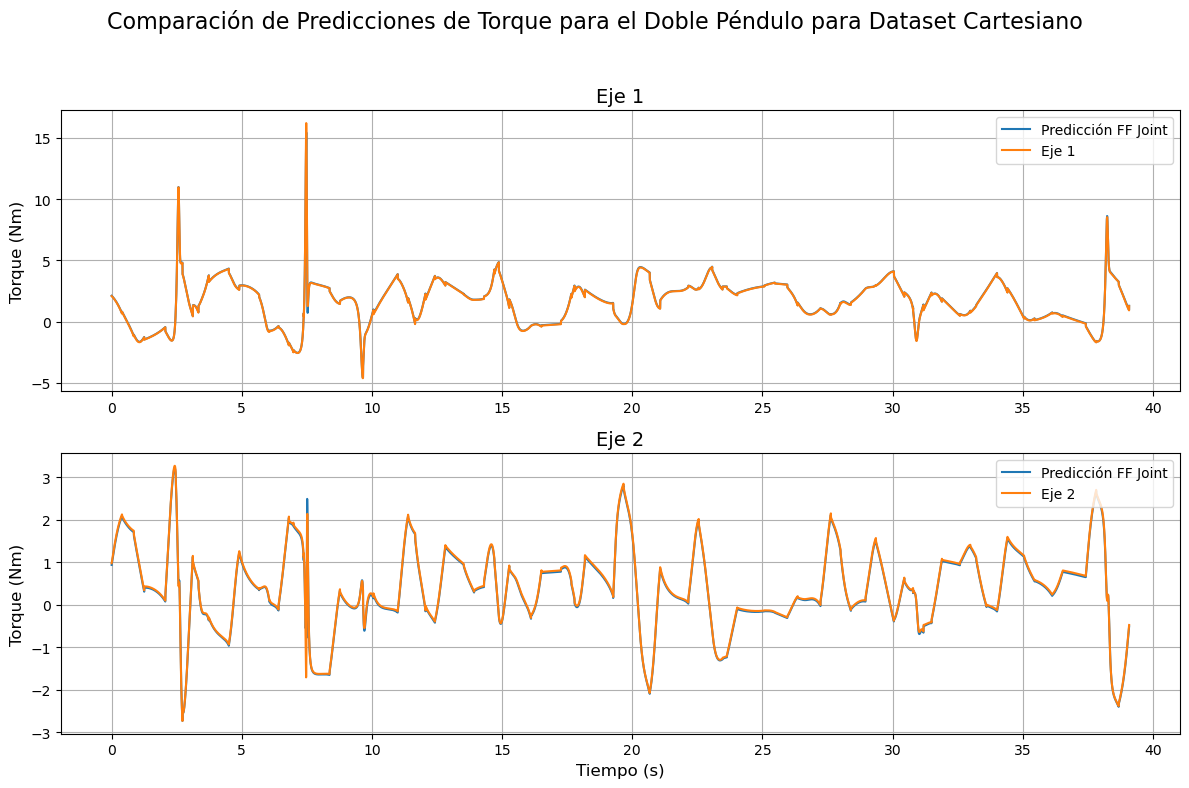

In [94]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Torque para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    plt.plot(t_ref_comp_cart, tau_sim_FF_NN_comp_cart_j[:, i], label='Predicción FF Joint')
    plt.plot(t_ref_comp_cart, outputs_ref_comp_cart[:, i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Torque (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


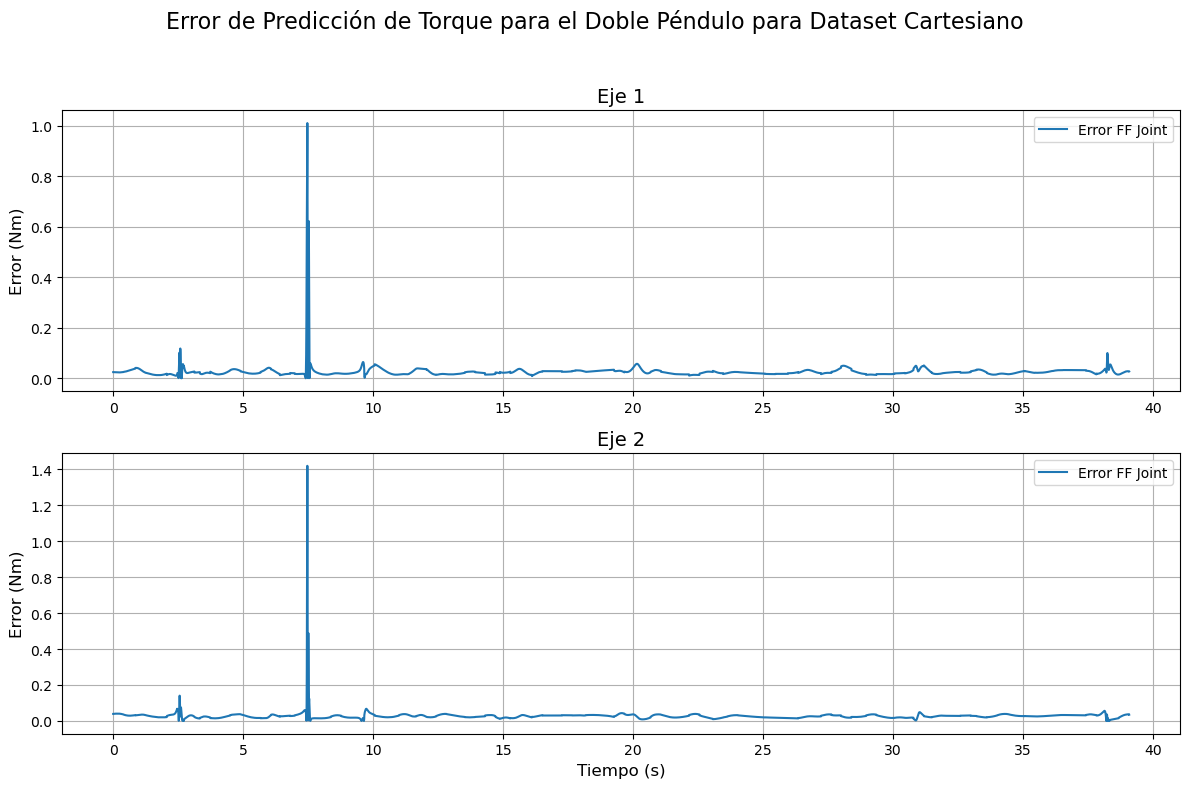

In [95]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Torque para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)

    error_OSA_Joint_c = np.sqrt((tau_sim_FF_NN_comp_cart_j[:, i] - outputs_ref_comp_cart[:, i])**2)

    # Graficar los errores
    plt.plot(t_ref_comp_cart, error_OSA_Joint_c, label='Error FF Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


# **Análisis de Ruido**

In [96]:
datos_2LRP_comp_joint_noise = pd.read_csv(f'./2LPR/DD_NN_Pos/DATA/Reconstruccion_2lpr_jointmovement_1e-3_2025_05_16-17_22_43.csv',delimiter=',', encoding="utf-8", skipinitialspace=True) #pos_noise_std=1e-3
#datos_2LRP_comp_joint_noise = pd.read_csv(f'./2LPR/DD_NN_Pos/DATA/Reconstruccion_2lpr_jointmovement_1e-4_2025_05_16-17_23_41.csv',delimiter=',', encoding="utf-8", skipinitialspace=True) #pos_noise_std=1e-4
#datos_2LRP_comp_joint_noise = pd.read_csv(f'./2LPR/DD_NN_Pos/DATA/Reconstruccion_2lpr_jointmovement_1e-6_2025_05_16-17_29_41.csv',delimiter=',', encoding="utf-8", skipinitialspace=True) #pos_noise_std=1e-6
#datos_2LRP_comp_joint_noise = pd.read_csv(f'./2LPR/DD_NN_Pos/DATA/Reconstruccion_2lpr_jointmovement_1e-8_2025_05_16-17_31_27.csv',delimiter=',', encoding="utf-8", skipinitialspace=True) #pos_noise_std=1e-8

std_level="1e-3"

t_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,1].values

q1_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,2].values
q2_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,3].values

dq1_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,4].values
dq2_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,5].values

ddq1_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,6].values
ddq2_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,7].values

t1_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,8].values
t2_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,9].values

q1_noise_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,10].values
q2_noise_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,11].values

dq1_noise_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,12].values
dq2_noise_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,13].values

ddq1_noise_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,14].values
ddq2_noise_comp_joint = datos_2LRP_comp_joint_noise.iloc[:,15].values

datos_2LRP_comp_joint_noise.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2,Theta_N_1,Theta_N_2,D_Theta_N_1,D_Theta_N_2,DD_Theta_N_1,DD_Theta_N_2
0,1,0.050001,-2.853574,-0.976601,0.013751,0.007088,13.751415,7.088245,-2.645024,-0.366420,-2.834207,-0.967979,1.018166,0.541050,0.193007,0.091789
1,2,0.051001,-2.853540,-0.976583,0.027503,0.014176,13.751415,7.088245,-2.638117,-0.362920,-2.833319,-0.968068,1.018549,0.541227,0.573652,0.264184
2,3,0.052001,-2.853492,-0.976558,0.041254,0.021265,13.751415,7.088245,-2.631197,-0.359438,-2.833378,-0.967430,1.019313,0.541584,0.952681,0.451463
3,4,0.053001,-2.853430,-0.976526,0.055006,0.028353,13.751415,7.088245,-2.624264,-0.355973,-2.833006,-0.967151,1.020453,0.542128,1.326158,0.634201
4,5,0.054001,-2.853354,-0.976487,0.068757,0.035441,13.751415,7.088245,-2.617319,-0.352526,-2.832587,-0.966976,1.021967,0.542851,1.706299,0.814260


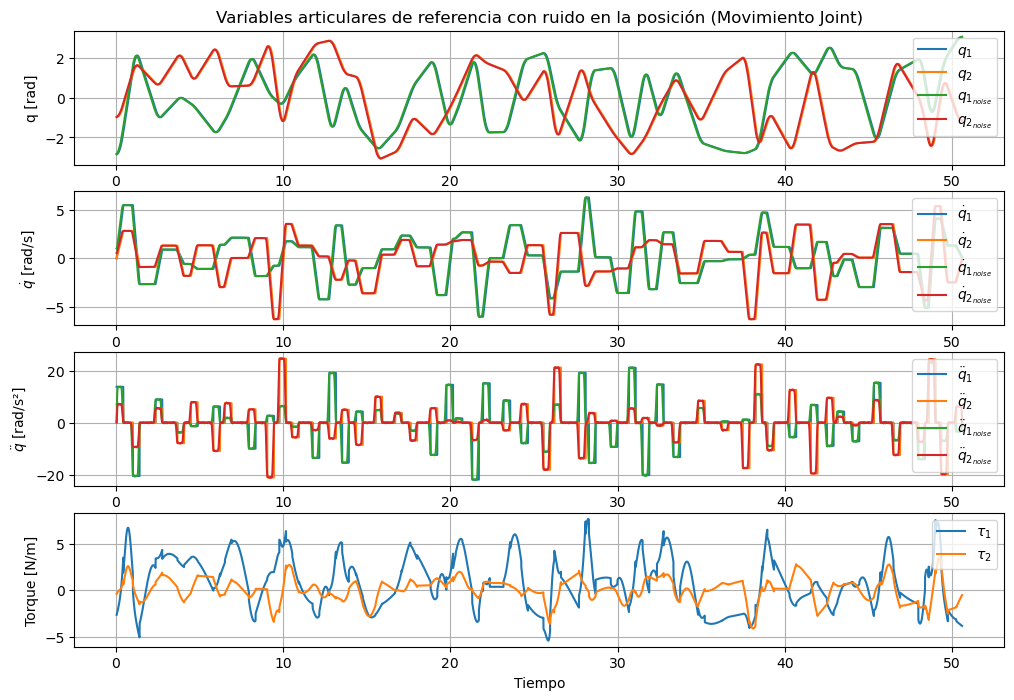

In [97]:
num_links = 2

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades
plt.subplot(4,1,1)
plt.plot(t_ref_comp_joint, q1_ref_comp_joint)
plt.plot(t_ref_comp_joint, q2_ref_comp_joint)
plt.plot(t_ref_comp_joint, q1_noise_comp_joint)
plt.plot(t_ref_comp_joint, q2_noise_comp_joint)
plt.legend([r'$q_1$', r'$q_2$', r'$q_{1_{noise}}$', r'$q_{2_{noise}}$'],loc='upper right', fontsize=10);  plt.ylabel('q [rad]')
plt.grid(True)
plt.title('Variables articulares de referencia con ruido en la posición (Movimiento Joint)')
plt.subplot(4,1,2)
plt.plot(t_ref_comp_joint, dq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, dq2_ref_comp_joint)
plt.plot(t_ref_comp_joint, dq1_noise_comp_joint)
plt.plot(t_ref_comp_joint, dq2_noise_comp_joint)
plt.legend([r'$\dot{q}_1$', r'$\dot{q}_2$', r'$\dot{q}_{1_{noise}}$', r'$\dot{q}_{2_{noise}}$'],loc='upper right', fontsize=10);  plt.ylabel(r'$\dot{q}$ [rad/s]')
plt.grid(True)
plt.subplot(4,1,3)
plt.plot(t_ref_comp_joint, ddq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, ddq2_ref_comp_joint)
plt.plot(t_ref_comp_joint, ddq1_noise_comp_joint)
plt.plot(t_ref_comp_joint, ddq2_noise_comp_joint)
plt.legend([r'$\ddot{q}_1$', r'$\ddot{q}_2$', r'$\ddot{q}_{1_{noise}}$', r'$\ddot{q}_{2_{noise}}$'],loc='upper right', fontsize=10);  plt.ylabel(r'$\ddot{q}$ [rad/s²]'); 
plt.grid(True)
plt.subplot(4,1,4)
plt.plot(t_ref_comp_joint, t1_ref_comp_joint)
plt.plot(t_ref_comp_joint, t2_ref_comp_joint)
plt.legend([r'$\tau_{1}$', r'$\tau_{2}$'],loc='upper right', fontsize=10); plt.xlabel('Tiempo'); plt.ylabel('Torque [N/m]')
plt.grid(True)
plt.show()

In [98]:
inputs_noise_comp_joint = np.vstack((q1_noise_comp_joint,q2_noise_comp_joint,dq1_noise_comp_joint,dq2_noise_comp_joint,ddq1_noise_comp_joint,ddq2_noise_comp_joint)).T
outputs_noise_comp_joint = np.vstack((t1_ref_comp_joint,t2_ref_comp_joint)).T

In [99]:
#Primero con FF NN

X_noise_scaled_FF_NN = scaler1_FF_t.transform(inputs_noise_comp_joint)
tau_noise_FF_NN = scaler2_FF_t.inverse_transform(FF_SS_network.predict(X_noise_scaled_FF_NN))

1580/1580 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step


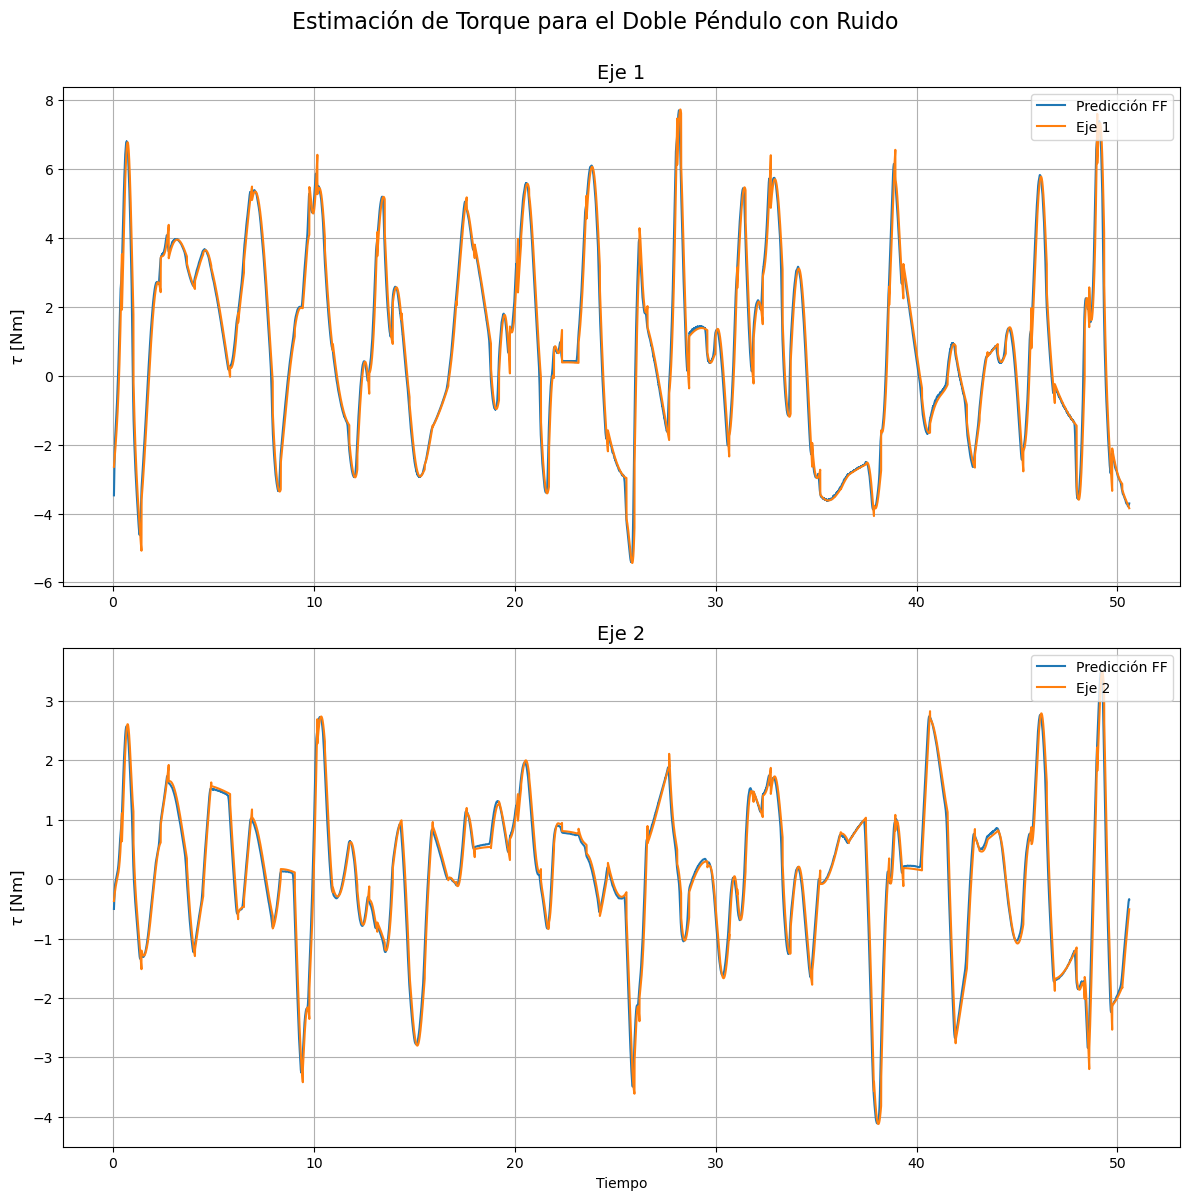

In [100]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Estimación de Torque para el Doble Péndulo con Ruido", fontsize=16)

# Grafico los resultados
for i in range(num_links):
  plt.subplot(num_links, 1, i+1)
  plt.plot(t_ref_comp_joint,tau_noise_FF_NN[:,i])
  plt.plot(t_ref_comp_joint,outputs_noise_comp_joint[:,i])
  plt.ylabel(r'$\tau$ [Nm]', fontsize=12)
  plt.legend(['Predicción FF', f'Eje {i+1}', f'Eje {i+1} Ideal'],loc='upper right', fontsize=10)
  plt.title(f'Eje {i+1}', fontsize=14)
  plt.grid(True)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Dejar espacio para el título general
plt.xlabel('Tiempo');
plt.show()

Eje 1:
FF - MAE: 2.969300e-01, MSE: 1.957769e-01, R²: 0.9730427037
Eje 2:
FF - MAE: 1.506904e-01, MSE: 4.685310e-02, R²: 0.9694209655


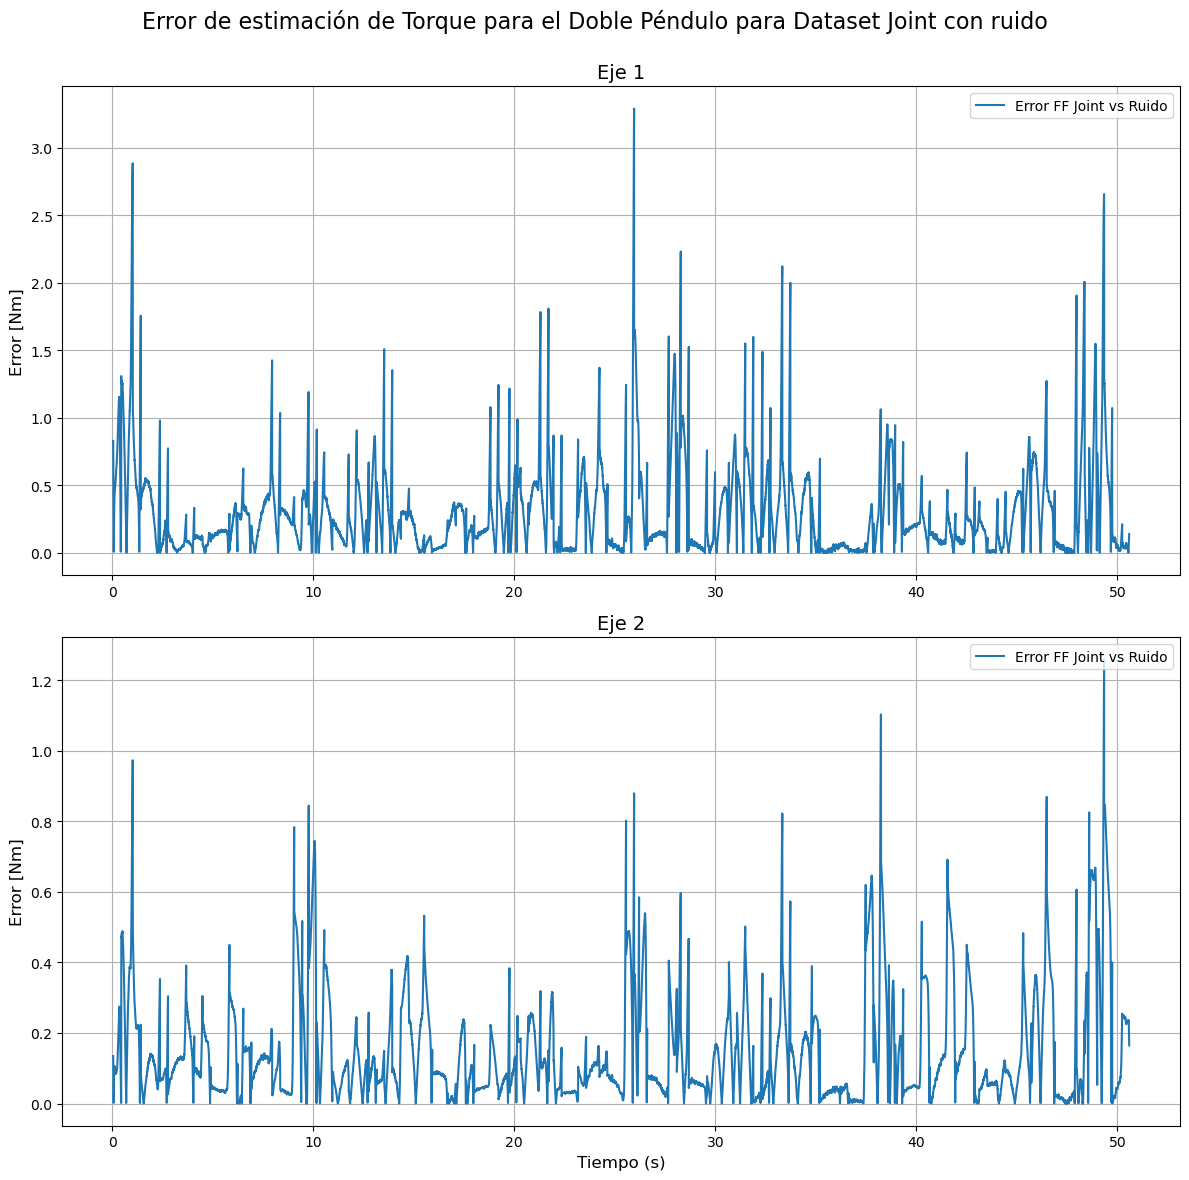

In [101]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de estimación de Torque para el Doble Péndulo para Dataset Joint con ruido", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)

    error_OSA_Joint_j_noise = np.sqrt((tau_noise_FF_NN[:, i] - outputs_noise_comp_joint[:, i])**2)

    # Para eje i (por ejemplo, eje 0 o 1)
    y_true = outputs_noise_comp_joint[:, i]             # Señal real con ruido
    y_pred_ff = tau_noise_FF_NN[:, i]                     # Predicción FF
    # MAE
    mae_ff = mean_absolute_error(y_true, y_pred_ff)
    # MSE
    mse_ff = mean_squared_error(y_true, y_pred_ff)
    # R²
    r2_ff = r2_score(y_true, y_pred_ff)

    # Imprimir resultados
    print(f"Eje {i+1}:")
    print(f"FF - MAE: {mae_ff:.6e}, MSE: {mse_ff:.6e}, R²: {r2_ff:.10f}")
   
    
    # Graficar los errores
    plt.plot(t_ref_comp_joint, error_OSA_Joint_j_noise, label='Error FF Joint vs Ruido')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error [Nm]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()